In [1]:
#Make sure you have the input file in the same folder as the notebook.

In [2]:
!pip install pandas --upgrade
!pip install scikit-learn --upgrade
!pip install matplotlib --upgrade


  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.me

In [3]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [5]:
data = pd.read_csv('docked_combined_python.csv')


In [6]:
data.head(10)

,ID,S,Rank,real
0,BI-7190,-8.274622,0,active
1,(S)-AU1,-6.818402,173,active
2,TP-238,-6.593113,689,active
3,BZ1,-6.414602,1698,active
4,BZ2,-6.332542,2443,active
5,BI-4827_NC,-6.274476,3080,Inactive
6,DC-BPi-11,-6.263610,3231,active
7,NVS-BPTF-1,-6.239370,3512,active
8,BZ1_NC,-6.017718,6854,active
9,GSK4027,-5.532773,13120,active


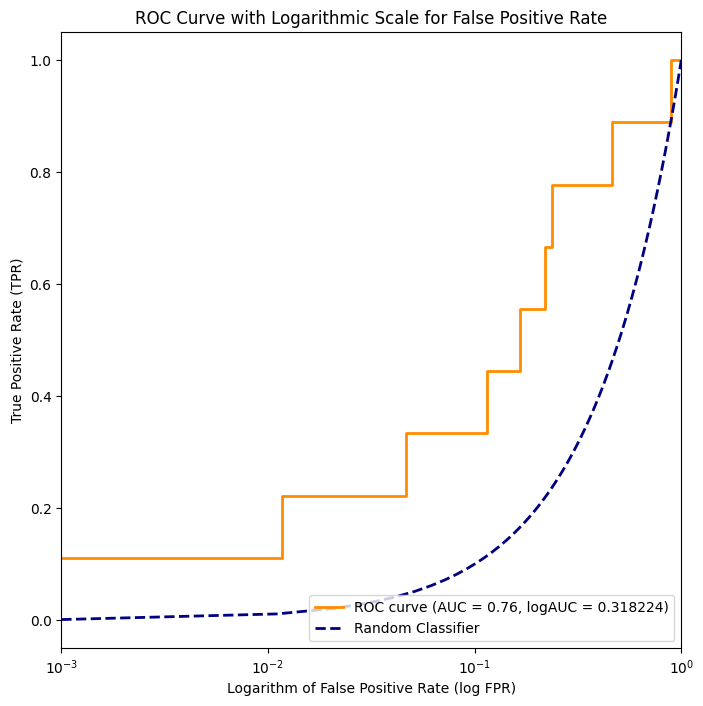

In [7]:
# Example DataFrame (replace this with your actual data)
# data = pd.DataFrame({'Rank': [...], 'real': [...]})

# Ensure the DataFrame contains the necessary columns and no NaNs
if 'Rank' not in data.columns or 'real' not in data.columns:
    raise ValueError("DataFrame must contain 'Rank' and 'real' columns")

# Drop rows with NaNs in 'Rank' or 'real'
data = data.dropna(subset=['Rank', 'real'])

# Assuming 'Rank' and 'real' are the correct column names
positive_class = 'active'

# Convert 'real' column to binary labels
data['binary_real'] = (data['real'] == positive_class).astype(int)

# Sorting the DataFrame based on the ranks ('Rank' column) in ascending order
data = data.sort_values(by='Rank', ascending=True)

# Calculate true positive rate (sensitivity), false positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(data['binary_real'], -data['Rank'])  # Negate 'Rank' to treat lower ranks as better
roc_auc = auc(fpr, tpr)

# Calculate logAUC using the provided formula
log_auc_threshold = 0.001
log_auc = 0.0

for i in range(len(fpr) - 1):
    if fpr[i] >= log_auc_threshold:
        log_auc += (np.log10(fpr[i + 1]) - np.log10(fpr[i])) * ((tpr[i + 1] + tpr[i]) / 2)

log_auc /= np.log10(1.0 / log_auc_threshold)

# Plotting ROC curve with linear scale for True Positive Rate (TPR) and logarithmic scale for False Positive Rate (FPR)
plt.figure(figsize=(8, 8))

# Take the logarithm of FPR
log_fpr = np.log10(fpr + 1e-10)  # Adding a small constant to avoid zero values

# Plot ROC curve
plt.plot(log_fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f}, logAUC = {log_auc:.6f})')

# Plot the random classifier line
random_fpr = np.linspace(log_auc_threshold, 1, 100)
random_tpr = random_fpr
log_random_fpr = np.log10(random_fpr)
plt.plot(log_random_fpr, random_tpr, color='navy', lw=2, linestyle='--', label='Random Classifier')

# Set x-axis limits from the log threshold to 0
plt.xlim(np.log10(log_auc_threshold), 0)

# Set x-axis ticks in the format of 10^x
xticks = np.arange(np.floor(np.log10(log_auc_threshold)), 1, 1)
xticklabels = [f'$10^{{{int(x)}}}$' for x in xticks]
plt.xticks(xticks, xticklabels)

plt.xlabel('Logarithm of False Positive Rate (log FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with Logarithmic Scale for False Positive Rate')
plt.legend(loc="lower right")
plt.show()